# Домашняя работа №2

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [32]:
data = pd.read_csv('Kobe.csv')

In [33]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [34]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

## Анализ данных

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [36]:
#Уберем строки с пустыми целевыми значениями, по идее в соревновании Кэггла надо дополнить пустые таргеты - спрогнозированными.
df =  data[pd.notnull(data[target])]

In [37]:
#Уберем явно бессмысленные атрибуты, shot_id уберем после сплита.
todrop = ['team_id', 'team_name', 'matchup', 'game_event_id', 'game_id', 'game_date']
for drop in todrop:
    df = df.drop(drop, 1)

(-50, 900)

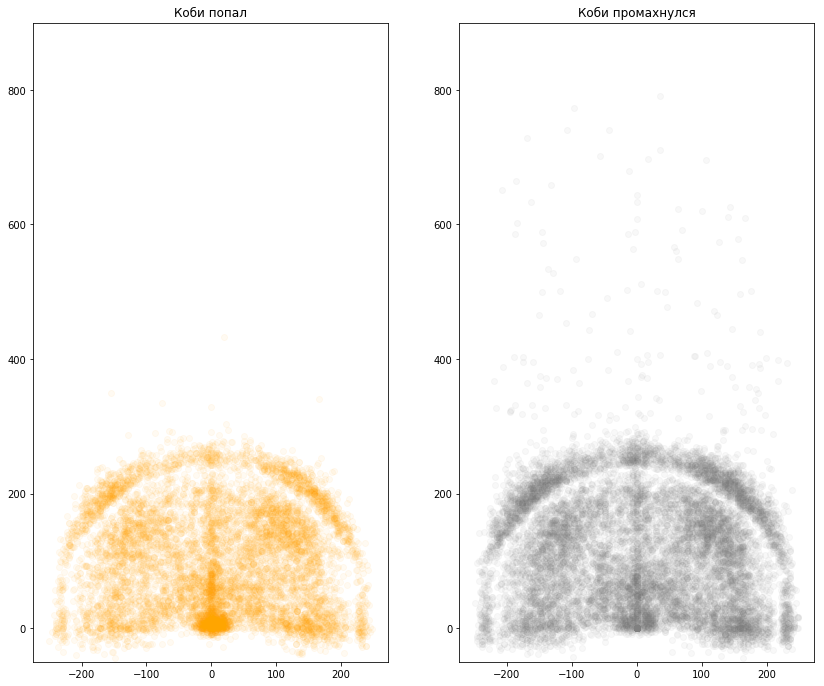

In [38]:
#Посмотрим на координаты бросков, есть ли большая разница на рисунках попаданий и промахов!
court_scale, alpha = 7, 0.05
plt.figure(figsize=(2 * court_scale, court_scale*(84.0/50.0)))
# Попадание
plt.subplot(121)
h = df.loc[df.shot_made_flag == 1]
plt.scatter(h.loc_x, h.loc_y, color='orange', alpha=alpha)
plt.title('Коби попал')
ax = plt.gca()
ax.set_ylim([-50, 900])
# Промах
plt.subplot(122)
h = df.loc[df.shot_made_flag == 0]
plt.scatter(h.loc_x, h.loc_y, color='grey', alpha=alpha)
plt.title('Коби промахнулся')
ax = plt.gca()
ax.set_ylim([-50, 900])

In [39]:
# Очевидно, из одинаковых позиций он и попадал и мазал.
# Дропнем все координаты, оставим дистанцию броска.
todrop = ['lon', 'lat', 'loc_x', 'loc_y', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic']
for drop in todrop:
    df = df.drop(drop, 1)

In [40]:
#Соединим минуты и секунды
df['remaining_time'] = df['minutes_remaining'] * 60 + df['seconds_remaining']
todrop = ['minutes_remaining', 'seconds_remaining']
for drop in todrop:
    df = df.drop(drop, 1)

In [41]:
df.head()

,action_type,combined_shot_type,period,playoffs,season,shot_distance,shot_made_flag,shot_type,opponent,shot_id,remaining_time
1,Jump Shot,Jump Shot,1,0,2000-01,15,0.0,2PT Field Goal,POR,2,622
2,Jump Shot,Jump Shot,1,0,2000-01,16,1.0,2PT Field Goal,POR,3,465
3,Jump Shot,Jump Shot,1,0,2000-01,22,0.0,2PT Field Goal,POR,4,412
4,Driving Dunk Shot,Dunk,2,0,2000-01,0,1.0,2PT Field Goal,POR,5,379
5,Jump Shot,Jump Shot,3,0,2000-01,14,0.0,2PT Field Goal,POR,6,572


### Посмотрим разные комбинации переменных и построим пару графиков.

In [42]:
df[['action_type', 'combined_shot_type', 'shot_type']].describe()

,action_type,combined_shot_type,shot_type
count,25697,25697,25697
unique,55,6,2
top,Jump Shot,Jump Shot,2PT Field Goal
freq,15836,19710,20285


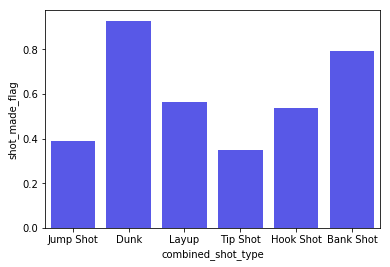

In [43]:
#Точность разных типов бросков
sns.barplot(x='combined_shot_type', y='shot_made_flag', data=df, ci=None, color='blue',
            alpha=0.75)

In [44]:
#Точность двухочковых и трехочковых
df.groupby('shot_type')['shot_made_flag'].agg({'accuracy' : 'mean', 'number' : 'count'})

/home/eli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,accuracy,number
shot_type,,
2PT Field Goal,0.477348,20285
3PT Field Goal,0.329268,5412


Text(0, 0.5, 'Дистанция')

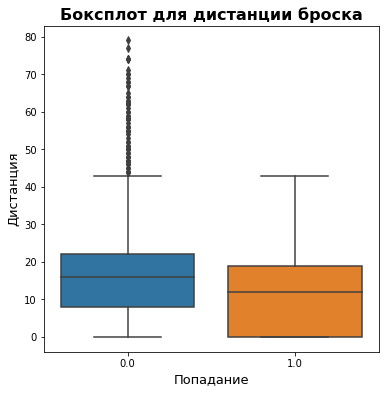

In [45]:
# Проверим как влияет расстояние
df['shot_made_flag_cat'] = df['shot_made_flag'].astype('category')
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
sns.boxplot(x='shot_made_flag_cat', y='shot_distance', data=df, ax=ax)
ax.set_title('Боксплот для дистанции броска', fontsize=16, fontweight='bold')
ax.set_xlabel('Попадание', fontsize=13)
ax.set_ylabel('Дистанция', fontsize=13)

In [46]:
#Как и предполагалось, тип броска и дистанция важны.

## Добавим категории, разделим данные на тест и трейн

In [47]:
# Преобразуем категориальные переменные!
cat_var = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']
for var in cat_var:
    df = pd.concat([df, pd.get_dummies(df[var], prefix=var)], 1)
    df = df.drop(var, 1)

In [48]:
# Разделим на трейн и тест
id_split = np.random.choice(df.shot_id.unique(), size=5000, replace=False)
df_train = df[~df.shot_id.isin(id_split)].copy()
print("Total transactions in train dataset: ", len(df_train))
df_test = df[df.shot_id.isin(id_split)].copy()
print("Total transactions in test dataset: ", len(df_test))

Total transactions in train dataset:  20697
Total transactions in test dataset:  5000


In [49]:
# Дропнем уже не нужный shot_id
df_train = df_train.drop('shot_id',1)
df_test = df_test.drop('shot_id',1)

In [50]:
# Дропнем shot_made_flag_cat который использовали для боксплота
df_train = df_train.drop('shot_made_flag_cat',1)
df_test = df_test.drop('shot_made_flag_cat',1)

In [51]:
train_x = df_train.drop([target], axis=1)
train_y = df_train[target]
train_y.head()

1    0.0
2    1.0
4    1.0
5    0.0
6    1.0
Name: shot_made_flag, dtype: float64

In [52]:
# Лог Регрессия
lor = LogisticRegression()
lor.fit(X=train_x, y=train_y)

/home/eli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [53]:
train_pred = lor.predict(train_x)
roc_auc_train = roc_auc_score(train_y, train_pred)
print("Train: ", roc_auc_train)

Train:  0.6622959083518006


In [54]:
# Ридж
rid = Ridge()
rid.fit(X=train_x, y=train_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [55]:
train_pred_rid = rid.predict(train_x)
roc_auc_train_rid = roc_auc_score(train_y, train_pred_rid)
print("Train: ", roc_auc_train_rid)

Train:  0.6987441510464477


In [56]:
# Лассо
las = Lasso()
las.fit(X=train_x, y=train_y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [57]:
train_pred_las = las.predict(train_x)
roc_auc_train_las = roc_auc_score(train_y, train_pred_las)
print("Train: ", roc_auc_train_las)

Train:  0.5184069702921763
